In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from math import sqrt
import qriemannopt as qro

### Many qubits IC POVM

In [2]:
def kron(A, B):
    """Kronecker product of two tensors
    Args:
        A: tf tensor of shape (q, n, k)
        B: tf tensor of shape (p, m, l)
    Returns:
        tf tensor of shape (q * p, n * m, k * l)"""
    AB = tf.tensordot(A, B, axes=0)
    AB = tf.transpose(AB, (0, 3, 1, 4, 2, 5))
    shape = AB.shape
    AB = tf.reshape(AB, (shape[0] * shape[1],
                         shape[2] * shape[3],
                         shape[4] * shape[5]))
    return AB

# Pauli matrices
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = tf.constant([[0 + 0j, -1j], [1j, 0 + 0j]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

# All Pauli matrices in one tensor
sigma = tf.concat([sigma_x[tf.newaxis],
                   sigma_y[tf.newaxis],
                   sigma_z[tf.newaxis]], axis=0)

# coordinates of thetrahedron peaks
s0 = tf.constant([0, 0, 1], dtype=tf.complex128)
s1 = tf.constant([2 * sqrt(2) / 3, 0, -1/3], dtype=tf.complex128)
s2 = tf.constant([-sqrt(2) / 3, sqrt(2 / 3), -1 / 3], dtype=tf.complex128)
s3 = tf.constant([-sqrt(2) / 3, -sqrt(2 / 3), -1 / 3], dtype=tf.complex128)

# coordinates of thetrahedron peaks in one tensor
s = tf.concat([s0[tf.newaxis],
               s1[tf.newaxis],
               s2[tf.newaxis],
               s3[tf.newaxis]], axis=0)

# One qubit thetrahedral POVM
M = 0.25 * (tf.eye(2, dtype=tf.complex128) + tf.tensordot(s, sigma, axes=1))

# Many qubits POVM
num_of_qubits = 5  # number of qubits
Mmq = M
for _ in range(num_of_qubits - 1):
    Mmq = kron(Mmq, M)

### Data set generation (measurements outcomes simulation)

In [3]:
num_of_meas = 100  # number of measurements

# Random density matrix
rho = tf.random.normal((2 ** num_of_qubits, 2 ** num_of_qubits, 2), dtype=tf.float64)
rho = qro.manifold.real_to_complex(rho)
rho = tf.linalg.adjoint(rho) @ rho
rho = rho / tf.linalg.trace(rho)

# Measurements simulation
P = tf.cast(tf.einsum('ijk,kj->i', Mmq, rho), dtype=tf.float64)
eps = tf.random.uniform((num_of_meas,
                         2 ** (2 * num_of_qubits)),
                        dtype=tf.float64)
eps = -tf.math.log(-tf.math.log(eps))
ind_set = tf.math.argmax(eps + tf.math.log(P), axis=-1)
M_set = tf.gather_nd(Mmq, ind_set[:, tf.newaxis])

### Learning

In [68]:
'''# Random density matrix (Variable)
rho_learned = tf.random.normal((2 ** num_of_qubits, 2 ** num_of_qubits, 2), dtype=tf.float64)
rho_learned = qro.manifold.real_to_complex(rho_learned)
rho_learned = tf.linalg.adjoint(rho_learned) @ rho_learned
rho_learned = rho_learned / tf.linalg.trace(rho_learned)
rho_learned = tf.Variable(qro.manifold.complex_to_real(rho_learned))
m = qro.manifold.DensM(metric='cholesky')
opt = qro.optimizers.RAdam(m, 0.1)'''
rho_learned = tf.Variable(tf.random.normal((2 ** num_of_qubits, 2 ** num_of_qubits, 2), dtype=tf.float64))
opt = tf.optimizers.Adam(0.001)
dist = []
losses = []
for _ in range(1000):
    with tf.GradientTape() as tape:
        rho_learned_c = qro.manifold.real_to_complex(rho_learned)
        rho_learned_c1 = tf.linalg.adjoint(rho_learned_c) @ rho_learned_c
        #rho_learned_c = qro.manifold.real_to_complex(rho_learned)
        trace = tf.reduce_sum(tf.linalg.diag_part(rho_learned_c1))
        rho_learned_c2 = rho_learned_c1 * (trace ** (-1))
        p = tf.cast(tf.einsum('ijk,kj->i', M_set, rho_learned_c2), dtype=tf.float64)
        loss = tf.reduce_mean(tf.math.log(p))
    grad = tape.gradient(loss, rho_learned)
    opt.apply_gradients(zip([grad], [rho_learned]))
    dist.append(0.5 * tf.reduce_sum(tf.abs(tf.linalg.eigvalsh(rho_learned_c2 - rho))))
    losses.append(loss)

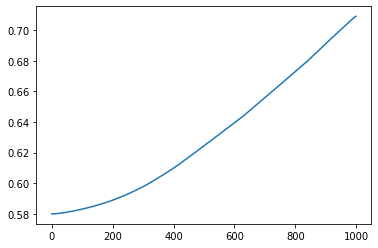

In [69]:
plt.plot(dist)

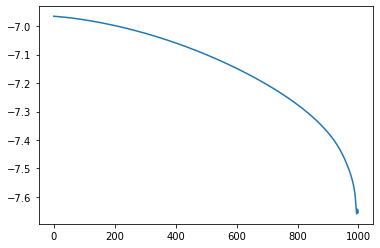

In [70]:
plt.plot(losses)

In [71]:
rho_learned

<tf.Variable 'Variable:0' shape=(32, 32, 2) dtype=float64, numpy=
array([[[ 0.00706903, -0.3932346 ],
        [-0.55879506,  0.2731243 ],
        [-0.61333802, -1.11076482],
        ...,
        [ 1.18935447,  0.46762781],
        [-0.63846236,  0.27145788],
        [ 1.21529091,  2.2386608 ]],

       [[-0.43057917, -0.77787285],
        [-1.34014554,  0.91312471],
        [-0.01579861, -0.61968848],
        ...,
        [-0.76486543,  0.58386027],
        [ 0.10270079,  0.67787332],
        [-0.06254831,  1.13294352]],

       [[-0.42004276, -1.09420895],
        [ 0.60915414,  0.3847198 ],
        [ 0.81437967, -0.29633845],
        ...,
        [-0.29191996,  0.87091581],
        [-1.64199924, -0.0636686 ],
        [ 0.12338084,  0.118681  ]],

       ...,

       [[-0.01992944, -0.71898353],
        [ 0.70414697,  0.41151326],
        [ 1.04018076,  1.37286745],
        ...,
        [ 0.42100325,  1.41123324],
        [-0.72983808, -1.37660355],
        [ 0.8157081 , -0.92330439]]

In [22]:
tf.reduce_min(tf.math.real(p))

<tf.Tensor: shape=(), dtype=float64, numpy=8.568175186651542e-06>